In [15]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord

from gwpy.time import tconvert

from pycbc.detector import Detector

L1_loc = SkyCoord('90 46 27.27', '30 33 46.42', unit =(u.deg, u.deg))
H1_loc = SkyCoord('119 24 27.56', '46 27 18.52', unit =(u.deg, u.deg))

In [16]:
def conv_to_sidereal(qt0):
    """
    Convert a UTC time in format qt0=[2004,3,18,0,0,0] to siderial time
    """
    yr=qt0[0]
    month=qt0[1]
    day=qt0[2];
    hr=qt0[3];
    mmin=qt0[4];
    sec=qt0[5]; 
    if month<=2:
        month=month+12
        yr=yr-1
    UT=hr+mmin/60.0+sec/3600.
    aa=np.floor(yr/100.)
    bb=2-aa+np.floor(aa/4.)
    JD=np.floor(365.25*(yr+4716))+np.floor(30.6001*(month+1))+day+bb-1524.5+UT/24.00


    ST=(JD-2451545.0)/36525 #Julian centries since 2000, Jan. 1 at 12 UT
    #local siderial time in degrees at Greenwich for the UT
    q0=280.46061837 + 360.98564736629*( JD -2451545.0) + 0.000387933* ST**2 - ST**3/38710000
    qt=q0+lo*180/np.pi#% ------------------ at detector site, in degrees

    qt=np.remainder(qt,360)
    qt=qt*np.pi/180
    return qt

In [17]:
### From Linqing's matlab code, ref Phys Rev D, 58, 063001 ###
def antenna_pattern_manual(eta, ga, la, lo, psi, qt, al, de):
    """
    eta = angle between IFO arms
    ga = angle between East and bisector of IFO arms
    la = latitude of detector
    lo = longditude of detector
    psi = polarization angle wrt IFO
    al = RA of source
    de = DEC of source
    
    returns antenna pattern functions fplus and fcross
    """
    a1 = ((1/16.)*sin(2*ga)*(3-cos(2*la))*(3-cos(2*de))*cos(2*(al-qt)))
    a2 = -((1/4.)*cos(2*ga)*sin(la)*(3-cos(2*de))*sin(2*(al-qt)))
    a3 = ((1/4.)*sin(2*ga)*sin(2*la)*sin(2*de)*cos(al-qt))
    a4  = -((1/2.)*cos(2*ga)*cos(la)*sin(2*de)*sin(al-qt))
    a5 = ((3/4.)*sin(2*ga)*(cos(la))**2*(cos(de))**2)
    a= a1 + a2 + a3 + a4 + a5


    b1 = cos(2*ga)*sin(la)*sin(de)*cos(2*(al-qt)) 
    b2 = (1/4.)*sin(2*ga)*(3-cos(2*la))*sin(de)*sin(2*(al-qt))  
    b3 = cos(2*ga)*cos(la)*cos(de)*cos(al-qt) 
    b4 = (1/2.)*sin(2*ga)*sin(2*la)*cos(de)*sin(al-qt)

    b = b1 + b2 + b3 + b4

    fp= sin(eta)*(a*cos(2*psi)+b*sin(2*psi))
    fc= sin(eta)*(b*cos(2*psi)-a*sin(2*psi))

    return fp, fc

In [31]:
#for ligo H
# eta = 90*np.pi/180.
# ga = 171.8*np.pi/180.
# la = 46.45*np.pi/180.
# lo = 119.41*np.pi/180.
# psi = 0


#for ligo L
eta = 90*np.pi/180.
ga = 243.0*np.pi/180.
la = 30.56*np.pi/180.
lo = -90.77*np.pi/180.
psi = 0*np.pi/180.

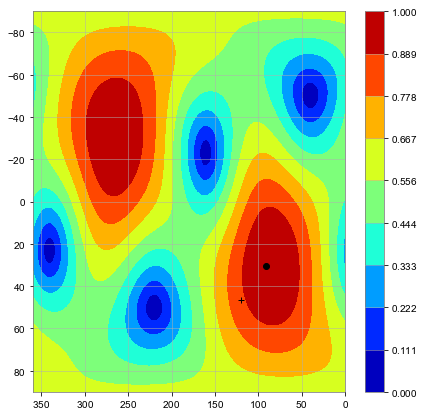

In [32]:
x = np.linspace(0, 2*np.pi, 100)
y = np.linspace(-np.pi/2, np.pi/2, 100)
xx, yy = np.meshgrid(x,y)

#to plot only
XX, YY = np.meshgrid(x*180/np.pi, y*180/np.pi)

### AN EXAMPLE: REPRODUCES FIGURE 1 OF WEN & SCHUTZ 2005
t = [2004,3,18,0,0,0]
qt = conv_to_sidereal(t)
fplus = np.zeros((100,100))
fcross = np.zeros((100,100))

for i in range(len(x)):
    for j in range(len(y)):
        #NOTE ORDERING OF I AND J
        fplus[j][i] = antenna_pattern_manual(eta, ga, la, lo, psi, qt,  x[i],y[j])[0]
        fcross[j][i] = antenna_pattern_manual(eta, ga, la, lo, psi, qt, x[i], y[j])[1]

r = np.sqrt(fplus**2 + fcross**2)
contour_levels = np.linspace(0, 1, 10)

fig, ax = plt.subplots(figsize = (7,7))
im = ax.contourf(XX, YY, r, 
                 contour_levels, cmap = 'jet')
ax.plot(L1_loc.ra.deg, L1_loc.dec.deg, 'ok')
ax.plot(H1_loc.ra.deg, H1_loc.dec.deg, '+k')
fig.colorbar(im)
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

### PS I THINK LINQING'S LOCATION OF HANFORD IS WRONG IN HER PAPER

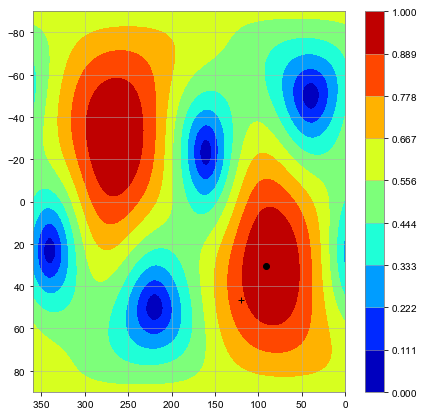

In [33]:
### COMPARISON TO PYCBC INBUILT FUNCTION:
pol = 0

Z_p_L1 = np.zeros((100,100))
Z_c_L1 = np.zeros((100,100))

d_L1 = Detector("L1")
for i in range(len(x)):
    for j in range(len(y)):
        fp_L1, fc_L1 = d_L1.antenna_pattern(x[i], y[j], pol, 763603213)
        #NOTE ORDERING OF I AND J
        Z_p_L1[j][i] = fp_L1
        Z_c_L1[j][i] = fc_L1

r1 = np.sqrt(Z_p_L1**2 + Z_c_L1**2)
fig, ax = plt.subplots(figsize = (7,7))
im = ax.contourf(XX, YY, r1, 
                 contour_levels, cmap = 'jet')
fig.colorbar(im)
ax.plot(L1_loc.ra.deg, L1_loc.dec.deg, 'ok')
ax.plot(H1_loc.ra.deg, H1_loc.dec.deg, '+k')
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()